## Camera calibration matrix and distortion coefficients

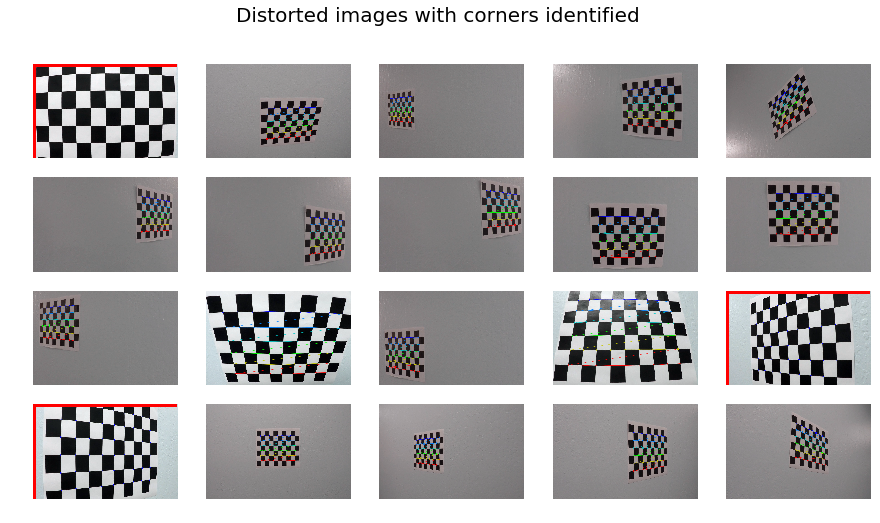

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline

# Read in and make a list of calibration images
path = 'camera_cal/'
images = glob.glob(path + 'calibration*.jpg')

# Array to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points
objp = np.zeros((9*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Configure plot
fig = plt.figure(facecolor="white")
fig.set_size_inches(15, 8)

for i in range(len(images)):
    # Read in each image
    img = cv2.imread(images[i])
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

    # Draw and display the corners
    ax=fig.add_subplot(4,5,i+1, aspect='equal'); 
    try:
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    except:
        pass
    ax.imshow(img);
    
    if ret != True:
        ax.axhline(linewidth=5, color="r")
        ax.axvline(linewidth=5, color="r")
    
    ax.axis('off');
    ax.axis('tight');
    
plt.suptitle('Distorted images with corners identified', fontsize = 20);

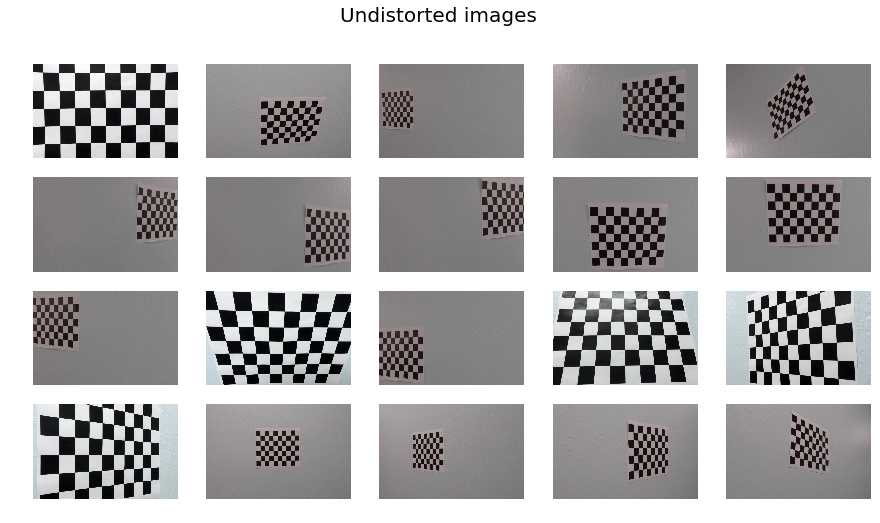

In [2]:
# Correction for distortion
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# Function to undistort a given
def undistort_image(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

# Configure plot
fig = plt.figure(facecolor="white")
fig.set_size_inches(15, 8)

for i in range(len(images)):
    img = cv2.imread(images[i])
    
    undist = undistort_image(img)
    
    ax=fig.add_subplot(4,5,i+1, aspect='equal'); 
    ax.imshow(undist);
    ax.axis('off');
    ax.axis('tight');
    
plt.suptitle('Undistorted images', fontsize = 20);

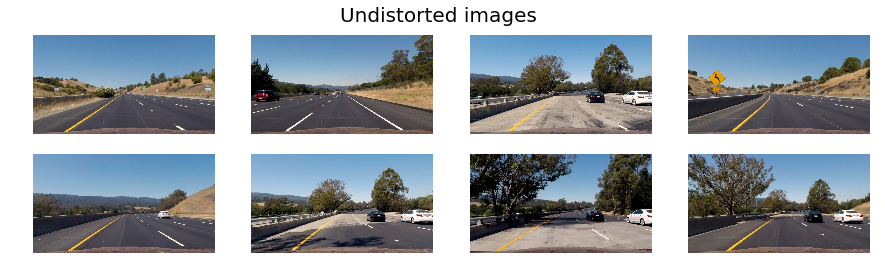

In [3]:
import os

path = "test_images//"
image_names = os.listdir(path)

# Configure plot
fig = plt.figure(facecolor="white")
fig.set_size_inches(15, 4)

for i in range(len(image_names)):
    img = cv2.imread(path + image_names[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    undist = undistort_image(img)
    
    ax=fig.add_subplot(2,4,i+1, aspect='equal'); 
    ax.imshow(undist);
    ax.axis('off');
    ax.axis('tight');
    
plt.suptitle('Undistorted images', fontsize = 20);

In [4]:
# Define perspective transfor function
def warp(img, p1x, p2x, p3x, p4x, pay, pby):
    
    img_size = (img.shape[1], img.shape[0])
    
    # Source coordinates
    src = np.float32(
                [[p1x, pay],
                 [p2x, pay],
                 [p3x, pby],
                 [p4x, pby]])     
    
    # Desired coordinates
    dst = np.float32(
                [[0, 0],
                 [img_size[0], 0],
                 [img_size[0], img_size[1]],
                 [0, img_size[1]]])  
    
    # Perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, src

def print_image(p1x, p2x, p3x, p4x, pay, pby):
    img = cv2.imread(path + image_names[1])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_warp, src = warp(img, p1x, p2x, p3x, p4x, pay, pby)

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10));
    ax1.imshow(img);
    ax2.imshow(img_warp);

### Adjust parameter for bird's-eye view

<function __main__.print_image>

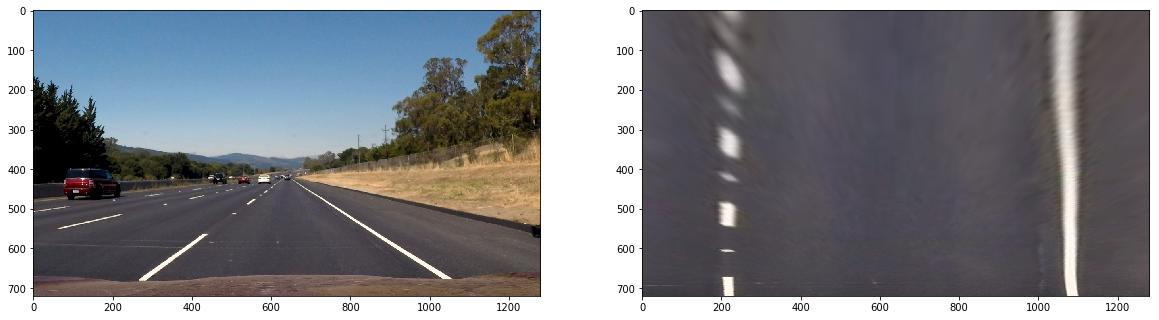

In [5]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display
    
interact(print_image, p1x=widgets.IntSlider(min=400,max=600,step=1,value=592),
                     p2x=widgets.IntSlider(min=500,max=700,step=1,value=690),
                     p3x=widgets.IntSlider(min=1000,max=1200,step=1,value=1180),
                     p4x=widgets.IntSlider(min=100,max=300,step=1,value=120),
                     pay=widgets.IntSlider(min=300,max=500,step=1,value=440),
                     pby=widgets.IntSlider(min=500,max=700,step=1,value=660),) 

## Apply sobel

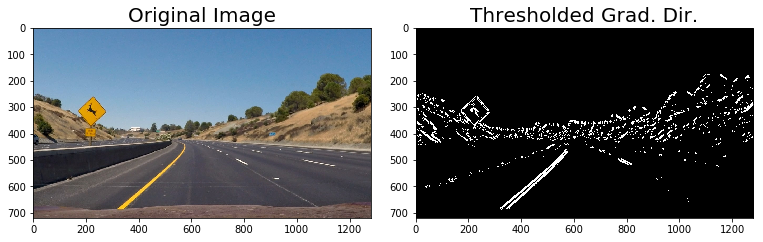

<function __main__.plot_threshold>

In [6]:
# Read in an image
img = cv2.imread(path + image_names[3])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobely = np.abs(sobely)
    abs_sobelx = np.abs(sobelx)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    graddir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255.0
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def plot_threshold(dir_kernel, dir_min, dir_max, mag_kernel, mag_min, mag_max, gradx_min, gradx_max, grady_min, grady_max):
    #def plot_threshold(gradx_min, gradx_max, grady_min, grady_max):
    # Run the function
    dir_binary = dir_threshold(img, sobel_kernel=dir_kernel, thresh=(dir_min, dir_max))
    mag_binary = mag_thresh(img, sobel_kernel=mag_kernel, mag_thresh=(mag_min, mag_max))
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=gradx_min, thresh_max=gradx_max)
    grady = abs_sobel_thresh(img, orient='x', thresh_min=grady_min, thresh_max=grady_max)

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Thresholded Grad. Dir.', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
interact(plot_threshold, dir_kernel=widgets.IntSlider(min=1,max=31,step=2,value=27),
                         dir_min=widgets.FloatSlider(min=0,max=1.5,step=.1,value=0.4),
                         dir_max=widgets.FloatSlider(min=0.8,max=2,step=.1,value=1.2),
                         mag_kernel=widgets.IntSlider(min=1,max=31,step=2,value=23),
                         mag_min=widgets.IntSlider(min=10,max=60,step=1,value=50),
                         mag_max=widgets.IntSlider(min=50,max=300,step=1,value=300),
                         gradx_min=widgets.IntSlider(min=0,max=100,step=1,value=66),
                         gradx_max=widgets.IntSlider(min=0,max=100,step=1,value=100),
                         grady_min=widgets.IntSlider(min=0,max=100,step=1,value=40),
                         grady_max=widgets.IntSlider(min=0,max=100,step=1,value=55))

### Color Threshold

<function __main__.img_threshold>

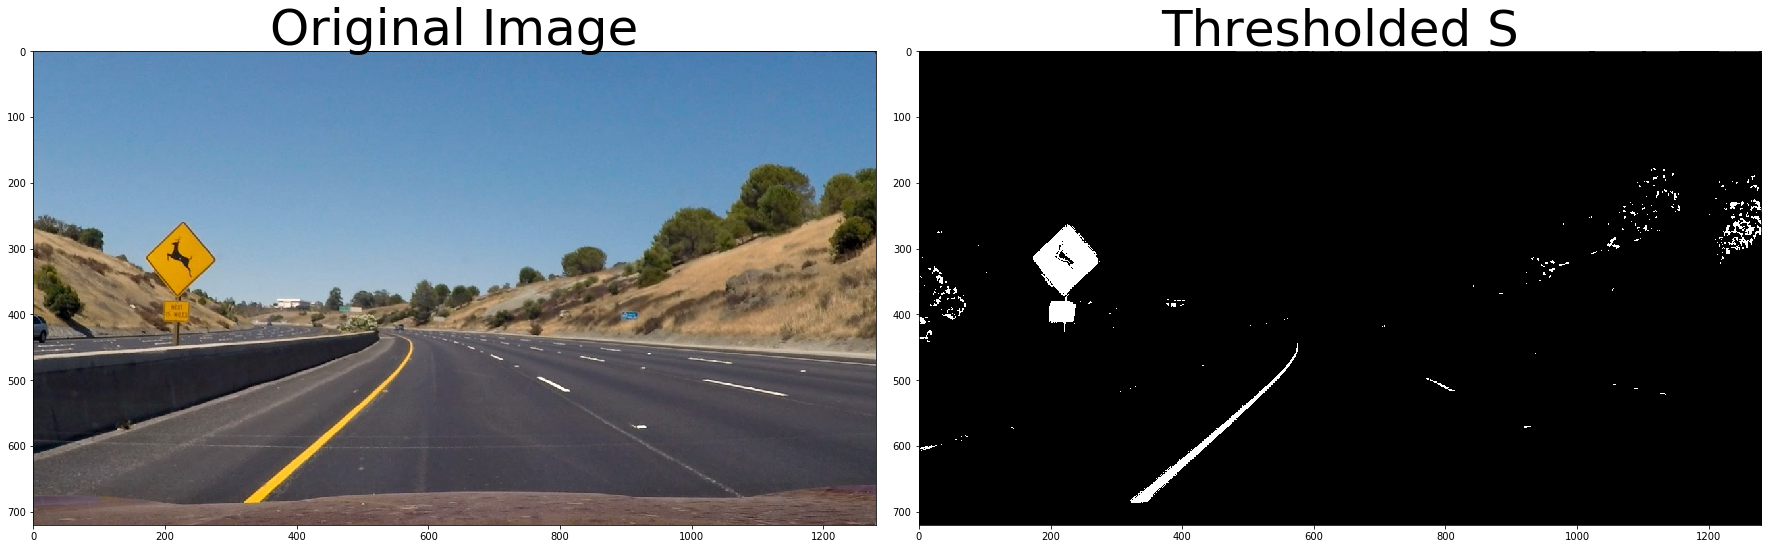

In [7]:
# Read in an image
img = cv2.imread(path + image_names[3])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output
    
def img_threshold(color_min, color_max):
    hls_binary = hls_select(img, thresh=(color_min, color_max))

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(hls_binary, cmap='gray')
    ax2.set_title('Thresholded S', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

interact(img_threshold, color_min=widgets.IntSlider(min=0,max=255,step=1,value=160),
                        color_max=widgets.IntSlider(min=0,max=255,step=1,value=255))

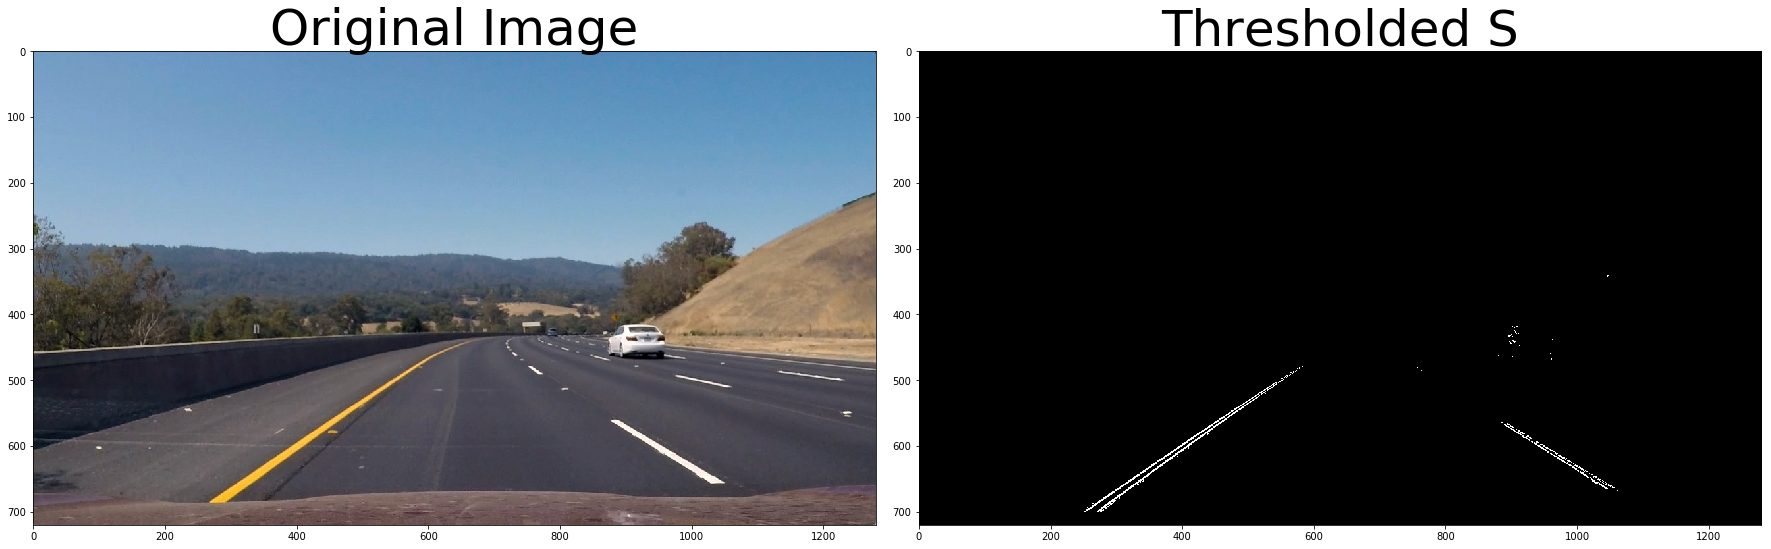

In [14]:
# Read in an image
img = cv2.imread(path + image_names[4])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

def pipeline(img):
    
    undist = undistort_image(img)
    
    hls_binary = hls_select(undist, thresh=(160, 255))
    
    dir_binary = dir_threshold(undist, sobel_kernel=27, thresh=(0.4, 1.2))
    mag_binary = mag_thresh(undist, sobel_kernel=23, mag_thresh=(50, 300))
    gradx = abs_sobel_thresh(undist, orient='x', thresh_min=66, thresh_max=100)
    grady = abs_sobel_thresh(undist, orient='x', thresh_min=40, thresh_max=55)
    
    combined = np.zeros_like(dir_binary)
    combined[(hls_binary == 1) & (((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)))] = 1
    
    img_warp, _ = warp(combined, 592, 690, 1180, 120, 440, 660)

    return combined
    
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(pipeline(img), cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)